# Precipition (pr)
conda env: new `phd_v3` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import calendar

import sys
sys.path.insert(1, '/home/lalandmi/Dropbox/Thèse/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]
Virtual memory usage - total: 31 GB / available: 23 GB / percent used: 23.4 %


In [2]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=slice(10,50)
lonlim=slice(60,110)

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

## Load elevation file

In [3]:
path = '/home/lalandmi/Dropbox/data/GMTED2010/'
ds = xr.open_dataset(path+'GMTED2010_15n120_0500deg.nc') \
    .drop_dims('nbounds') \
    .swap_dims({'nlat': 'latitude', 'nlon': 'longitude'}) \
    .drop({'nlat', 'nlon'}) \
    .rename({'latitude': 'lat', 'longitude': 'lon'}) \
    .sel(lat=latlim, lon=lonlim)

elevation = ds.elevation
elevation_std = ds.elevation_stddev

## APHRODITE http://aphrodite.st.hirosaki-u.ac.jp/download/data/search/  
http://aphrodite.st.hirosaki-u.ac.jp/download/
V1101 et V1101EX_R1 domain MA

Je pense que c'est ok de prendre ces deux là, car c'est la même version du coup même méthode ?

In [4]:
obs_V1101 = xr.open_mfdataset(
    '/home/lalandmi/Dropbox/data/APHRODITE/APHRO_MA_050deg_V1101.*.nc', combine='by_coords'
).precip
obs_V1101_EXR1 = xr.open_mfdataset(
    '/home/lalandmi/Dropbox/data/APHRODITE/APHRO_MA_050deg_V1101_EXR1.*.nc', combine='by_coords'
).precip
obs_V1101 = obs_V1101.rename({'longitude': 'lon', 'latitude': 'lat'})
obs = xr.combine_nested([obs_V1101, obs_V1101_EXR1], concat_dim='time')

# Resample monthly
aphro = obs.resample(time='1MS').mean('time').sel(lat=latlim_ext, lon=lonlim_ext, time=period)

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


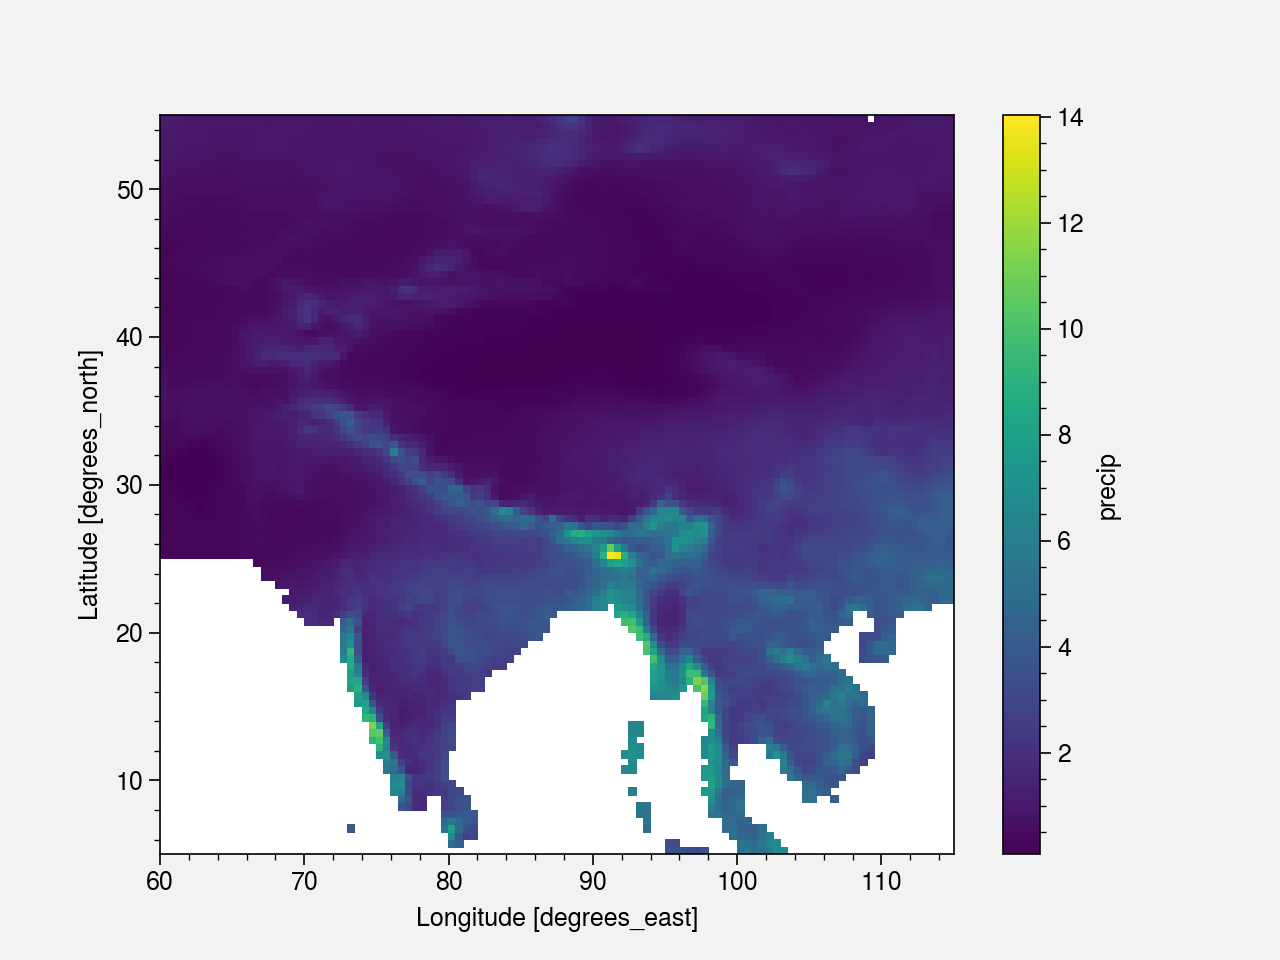

In [96]:
aphro.mean('time').plot()

In [5]:
aphro_mon = aphro.groupby('time.month').mean().load()

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


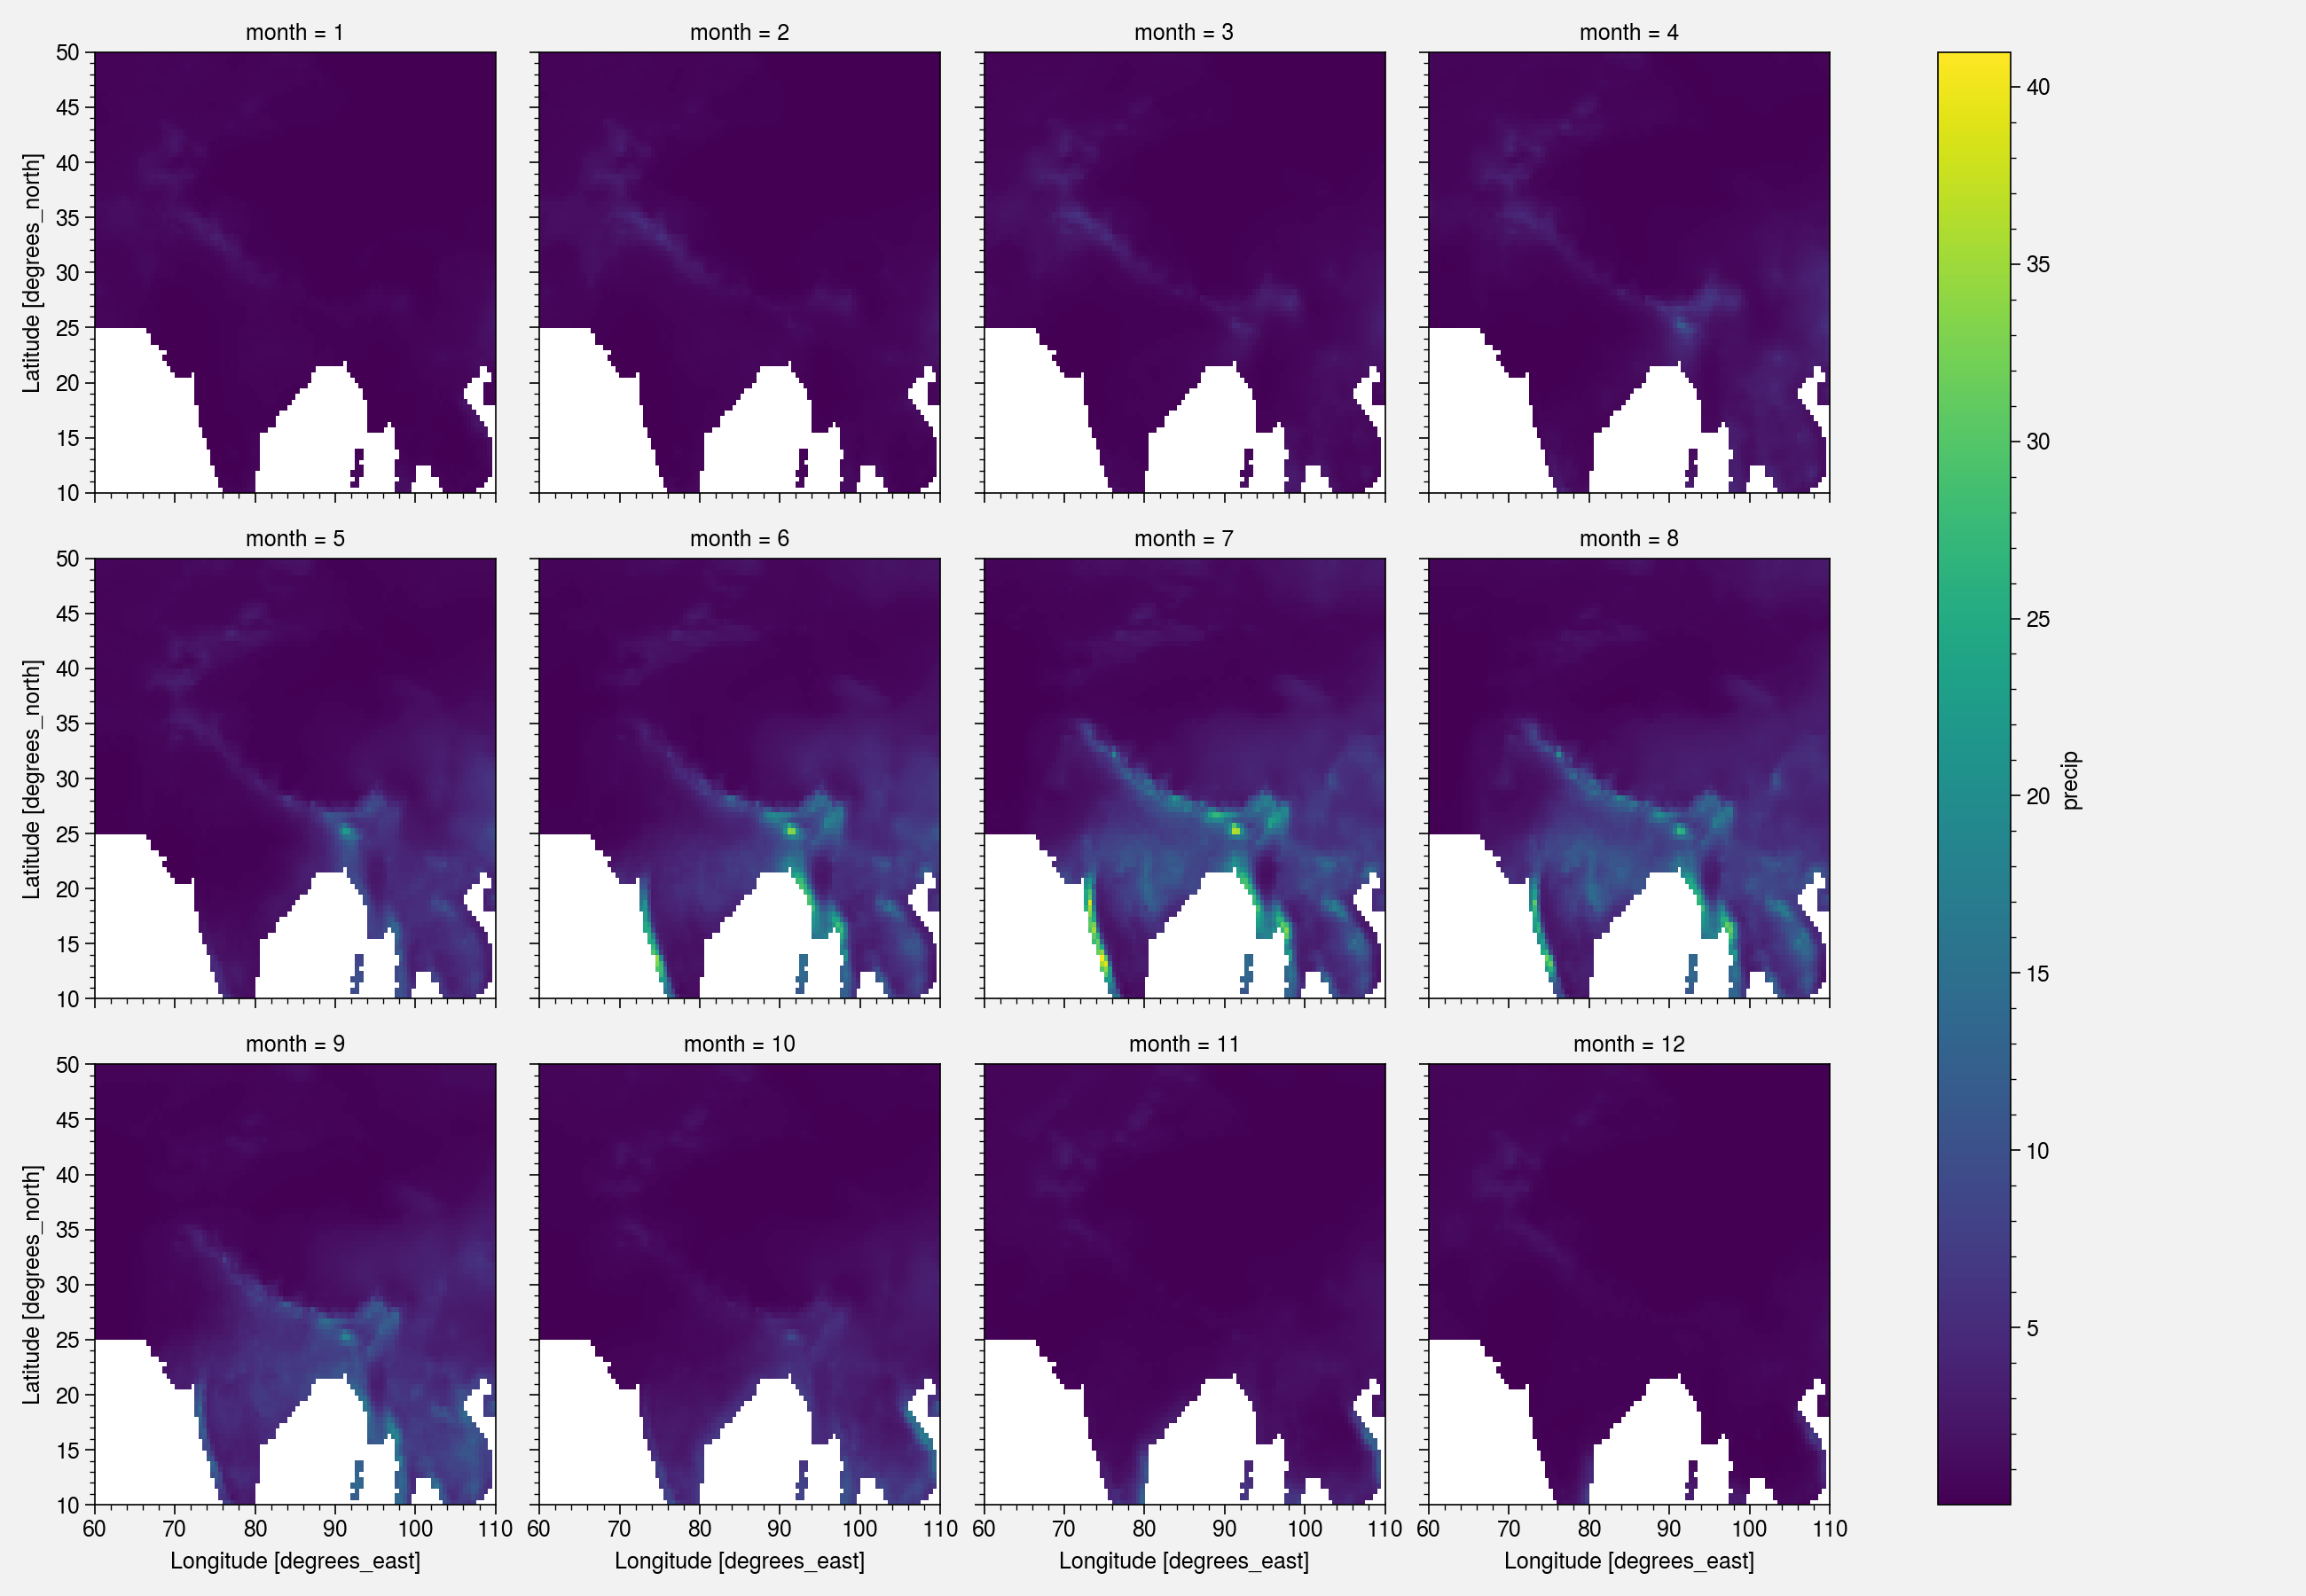

In [37]:
aphro_mon.plot(col='month', col_wrap=4)

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


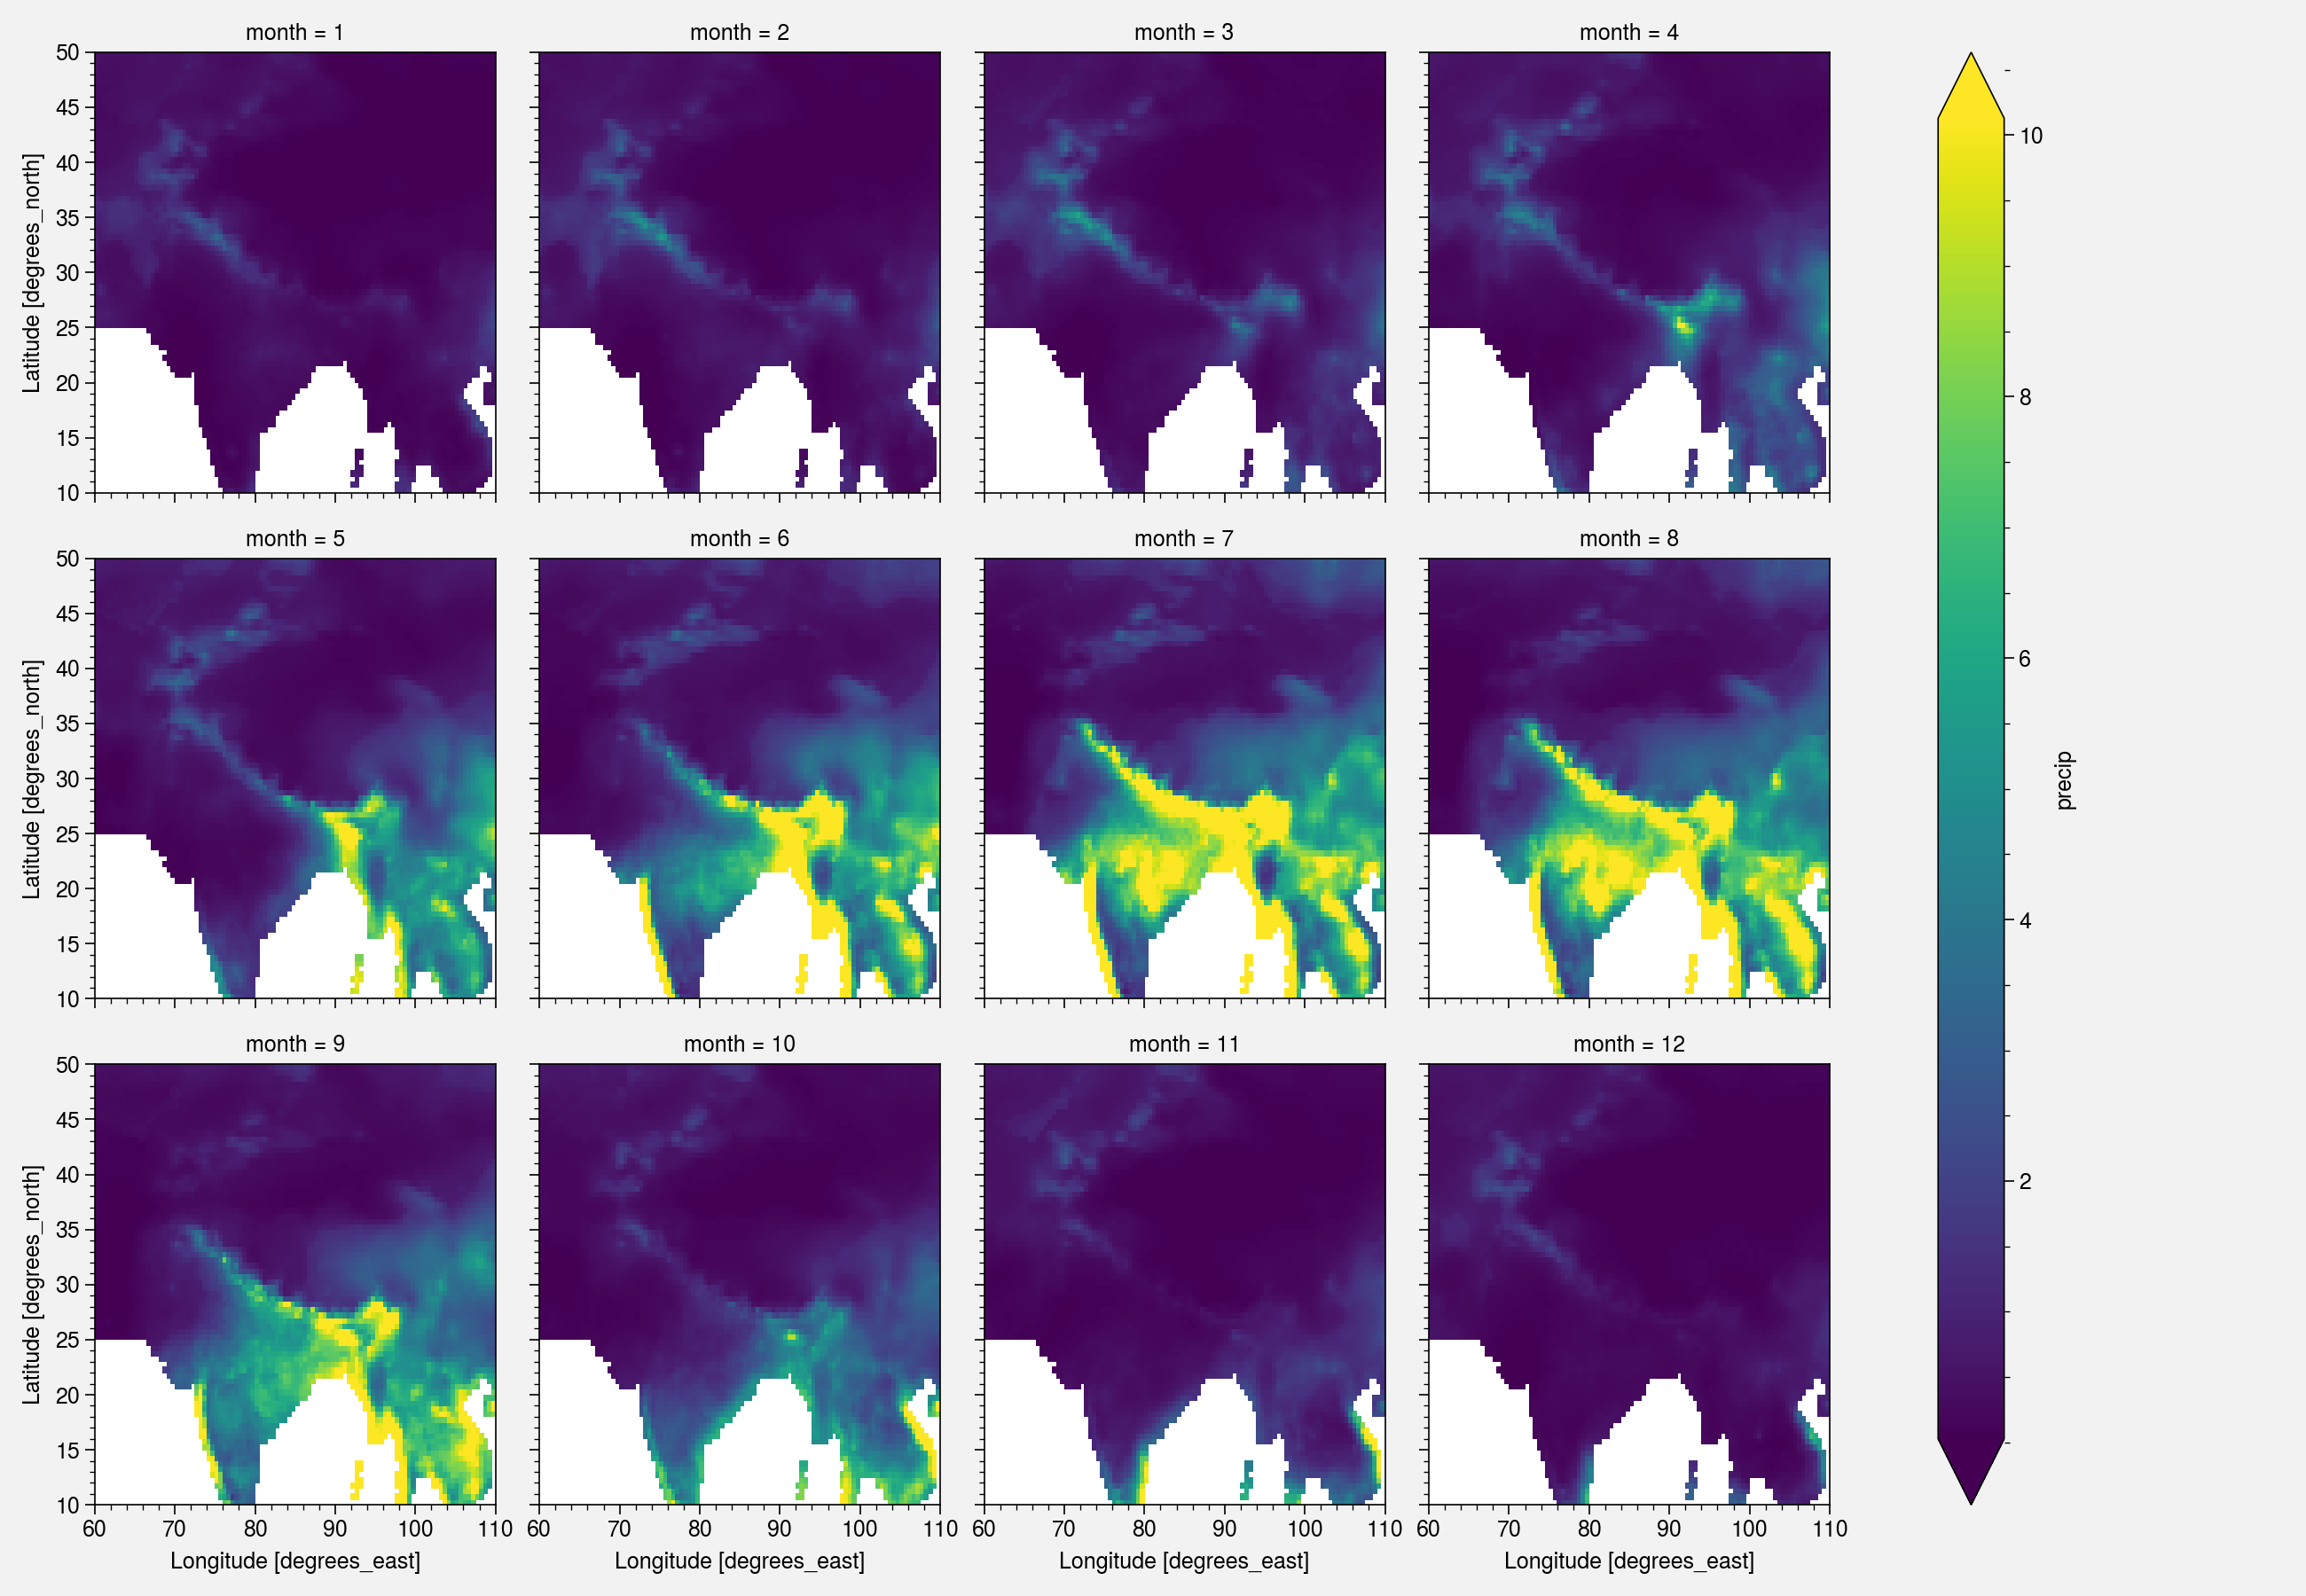

In [17]:
aphro_mon.plot(col='month', col_wrap=4, robust=True)

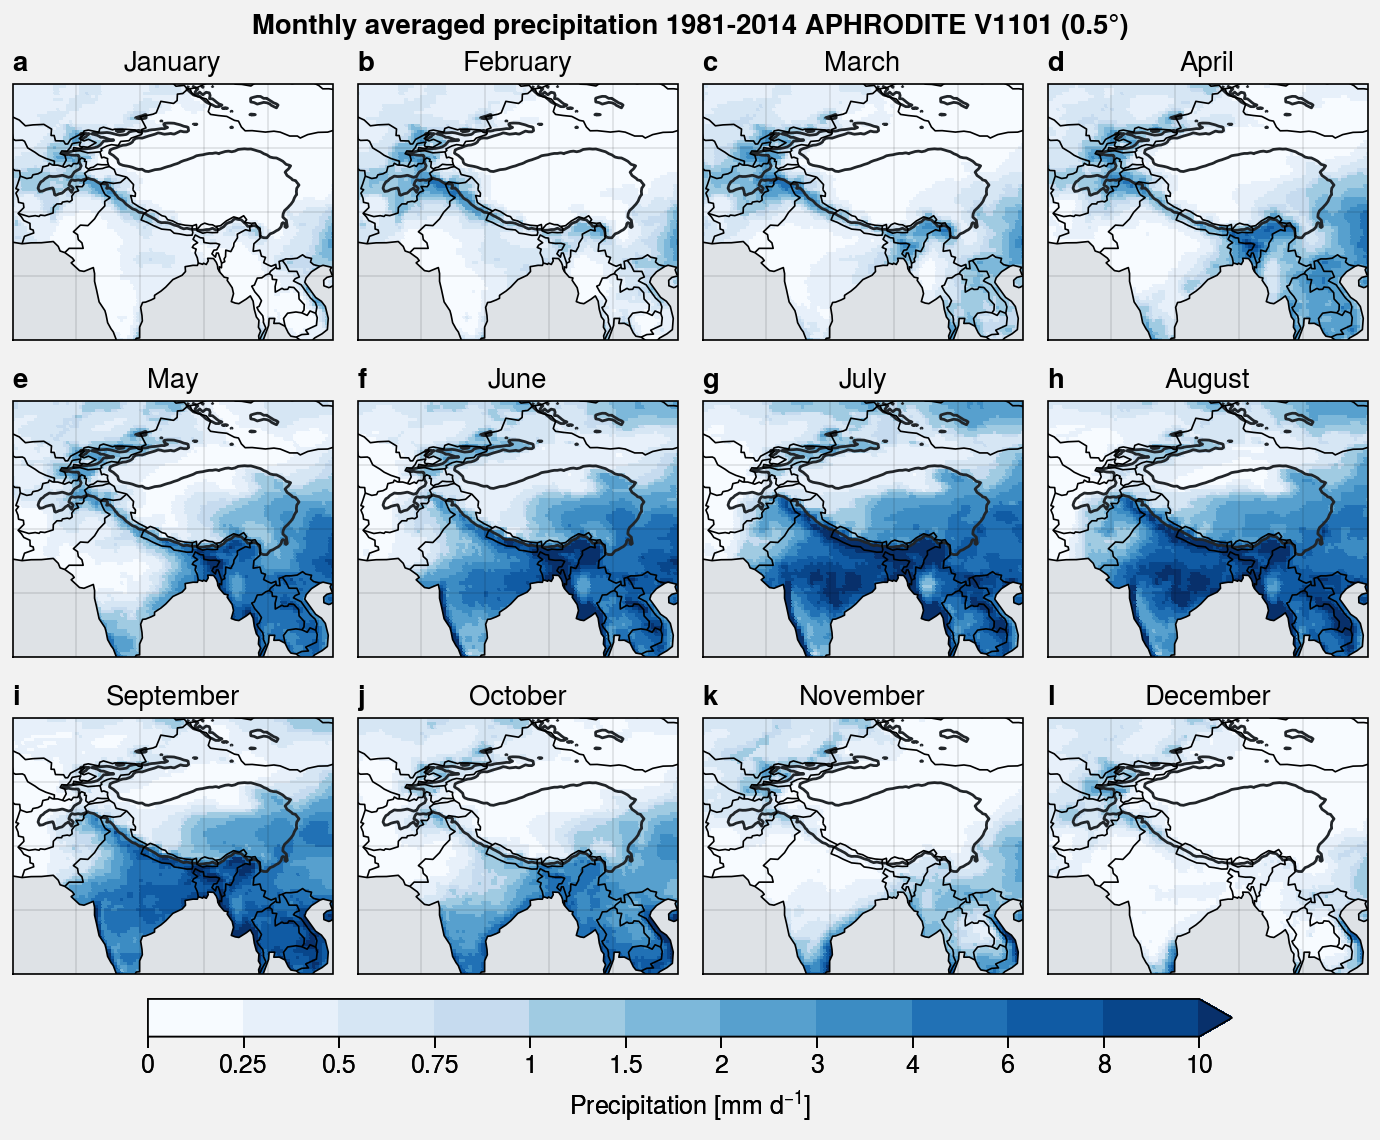

In [8]:
cmap='Blues'
# levels=plot.arange(0,10,1)
levels=[0, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4, 6, 8, 10]

# Define zone
latlim=slice(10,50)
lonlim=slice(60,110)

f, axs = plot.subplots(proj='cyl', ncols=4, nrows=3, share=3, axwidth=1.6)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        aphro_mon.isel(month=i), 
        cmap=cmap,  
        levels=levels,
        extend='max'
    )
    ax.format(title=calendar.month_name[i+1])
    
for ax in axs:
    ax.contour(elevation, levels=[2500], color='gray9', linewidth=1)
    
f.colorbar(m, label='Precipitation [mm d$^{-1}$]', loc='b', length=0.8)

axs.format(
    labels=False, coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle='Monthly averaged precipitation 1981-2014 APHRODITE V1101 (0.5°)',
    lonlines=10, latlines=10, abc=True, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop)
)

for ext in ['jpg', 'pdf']:
    f.save('img/aphro_mon_1981-2014.'+ext)

## CRU

https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.06/cruts.2205201912.v4.06/pre/  
Dowloaded: 25/08/2022 Mickaël Lalande

In [97]:
ds = xr.open_mfdataset(
    '/home/lalandmi/Dropbox/data//CRU/cru_ts4.06/pre/*nc'
).sel(time=period, lat=latlim_ext, lon=lonlim_ext)

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


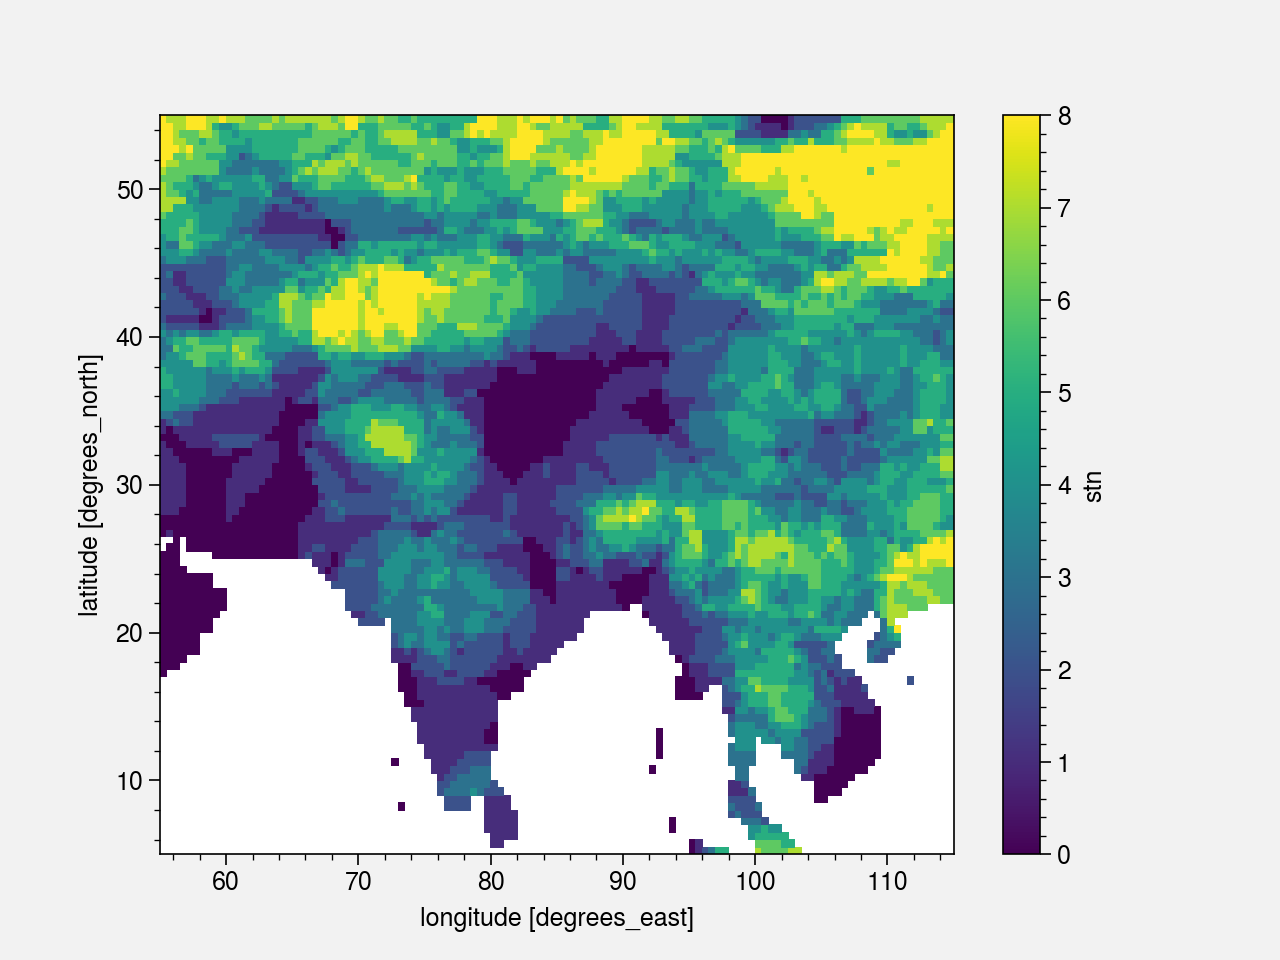

In [98]:
ds.stn.min('time').plot()

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


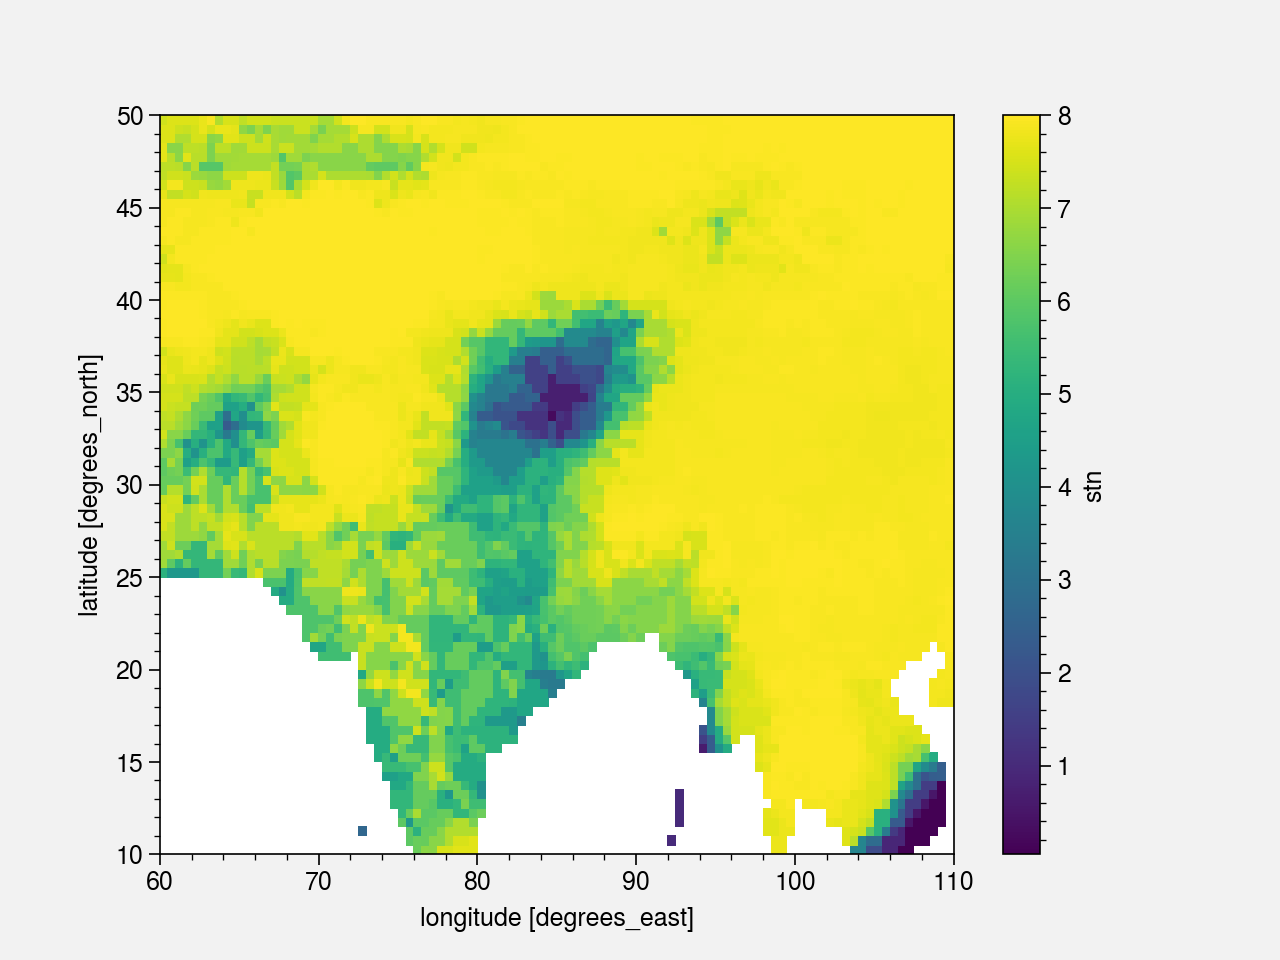

In [49]:
ds.stn.mean('time').plot()

In [52]:
ds.pre

<xarray.DataArray 'pre' (time: 408, lat: 80, lon: 100)>
dask.array<getitem, shape=(408, 80, 100), dtype=float32, chunksize=(120, 80, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 10.25 10.75 11.25 11.75 ... 48.25 48.75 49.25 49.75
  * lon      (lon) float32 60.25 60.75 61.25 61.75 ... 108.75 109.25 109.75
  * time     (time) datetime64[ns] 1981-01-16 1981-02-15 ... 2014-12-16
Attributes:
    long_name:                   precipitation
    units:                       mm/month
    correlation_decay_distance:  450.0

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


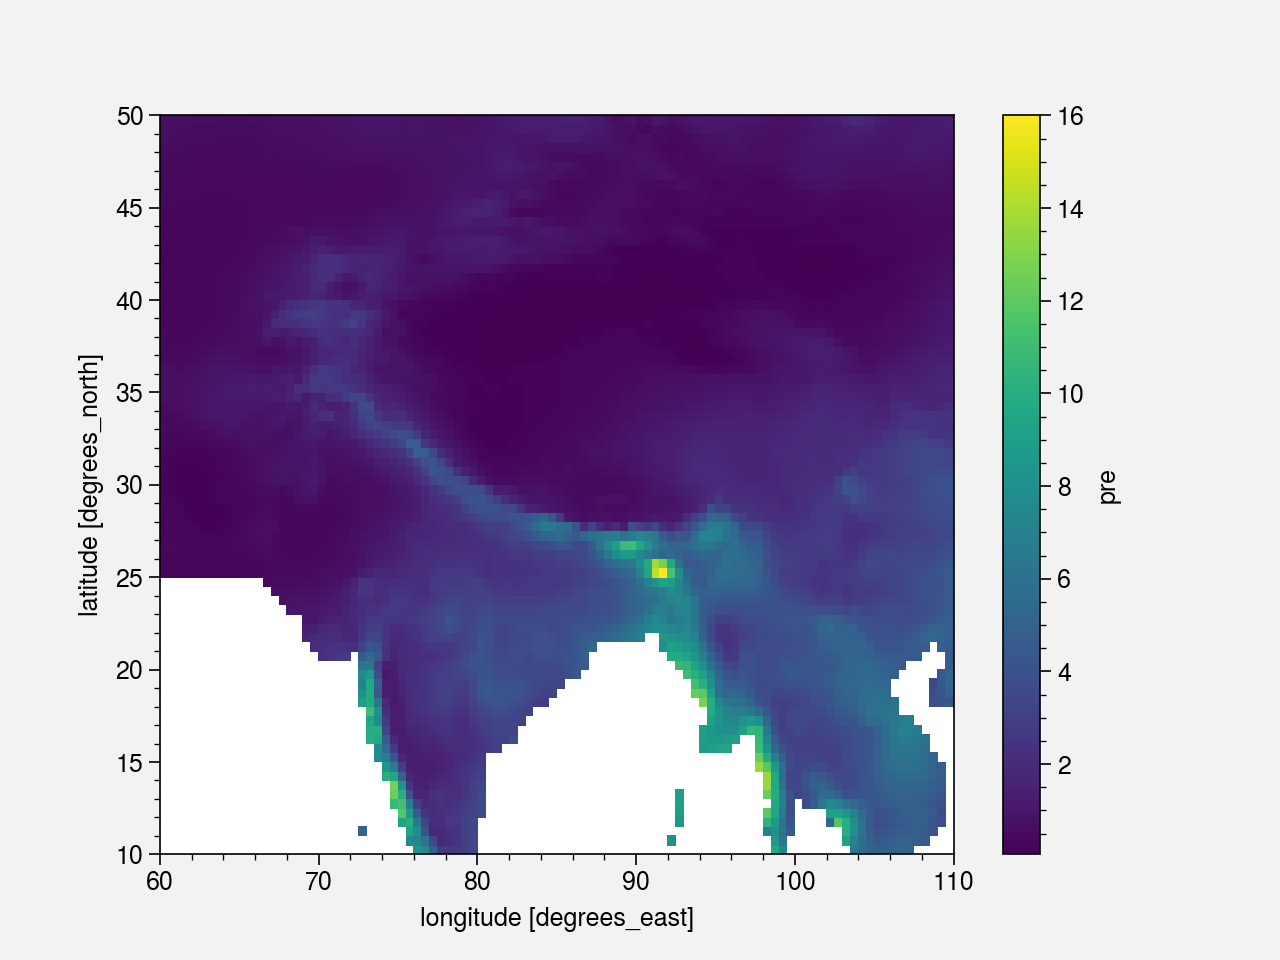

In [53]:
(ds.pre.mean('time') / 30).plot()

In [99]:
cru = ds.pre / ds.time.dt.days_in_month

## GPCP CDR v2.3 (2.5°)
https://www.ncdc.noaa.gov/cdr/atmospheric/precipitation-gpcp-monthly

In [100]:
ds = xr.open_mfdataset(
    '/home/lalandmi/Dropbox/data/GPCP/CDR_monthly_v2.3/*/gpcp_v02r03_monthly_d*_c20170616.nc'
).precip.sel(time=period, latitude=latlim_ext, longitude=lonlim_ext)

gpcp = ds.rename({'longitude': 'lon', 'latitude': 'lat'})

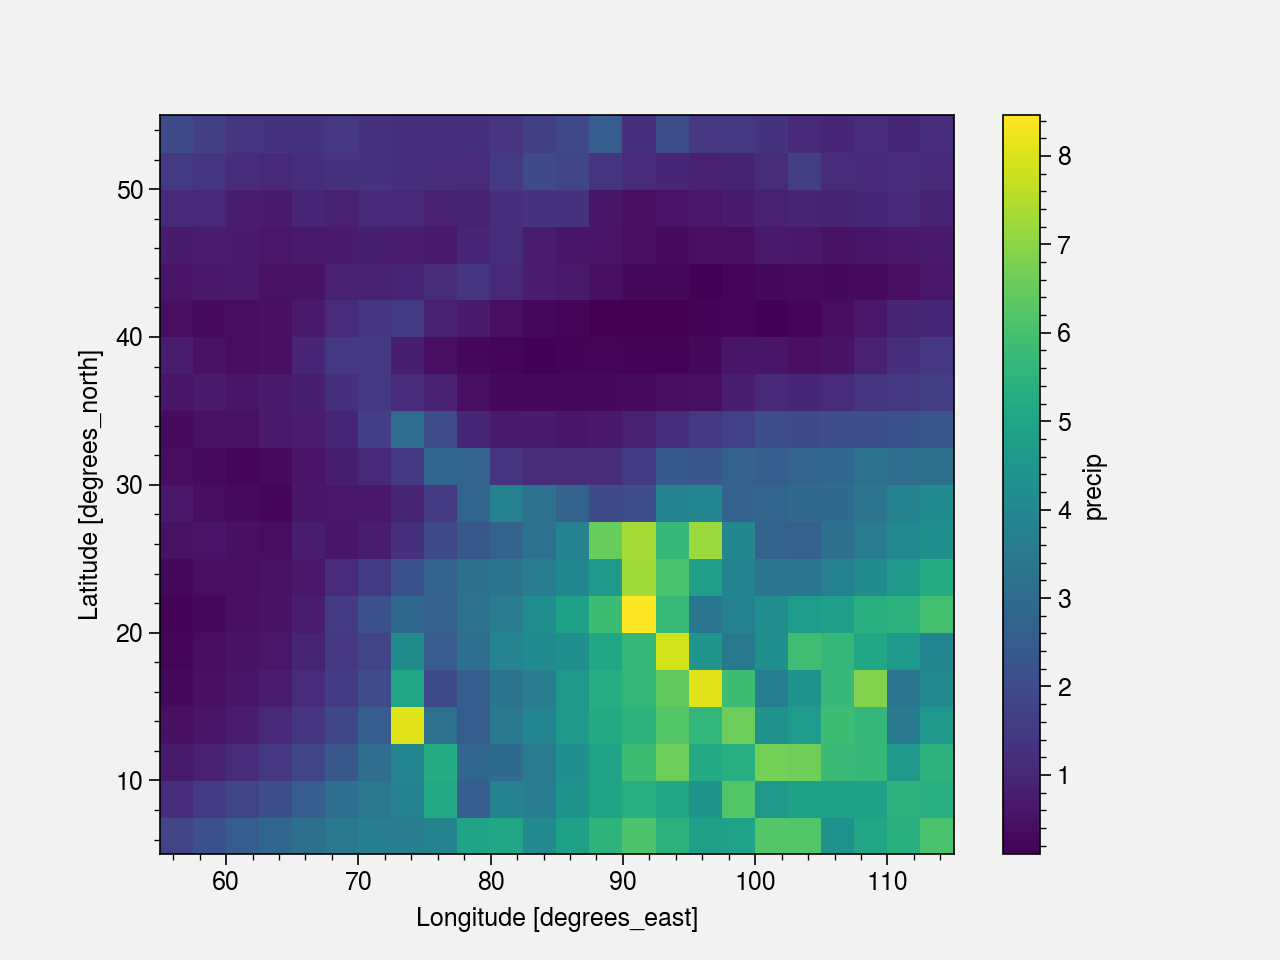

In [101]:
gpcp.mean('time').plot()

## Load CMFD

In [102]:
path = '/home/lalandmi/Dropbox/data/TPDC/china_meteorological_forcing_dataset_1979_2018/Data_forcing_01mo_010deg/'

ds = xr.open_dataset(path+'prec_CMFD_V0106_B-01_01mo_010deg_197901-201812.nc')
cmfd = ds.prec.sel(time=period, lat=latlim_ext, lon=lonlim_ext)
cmfd *= 24

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


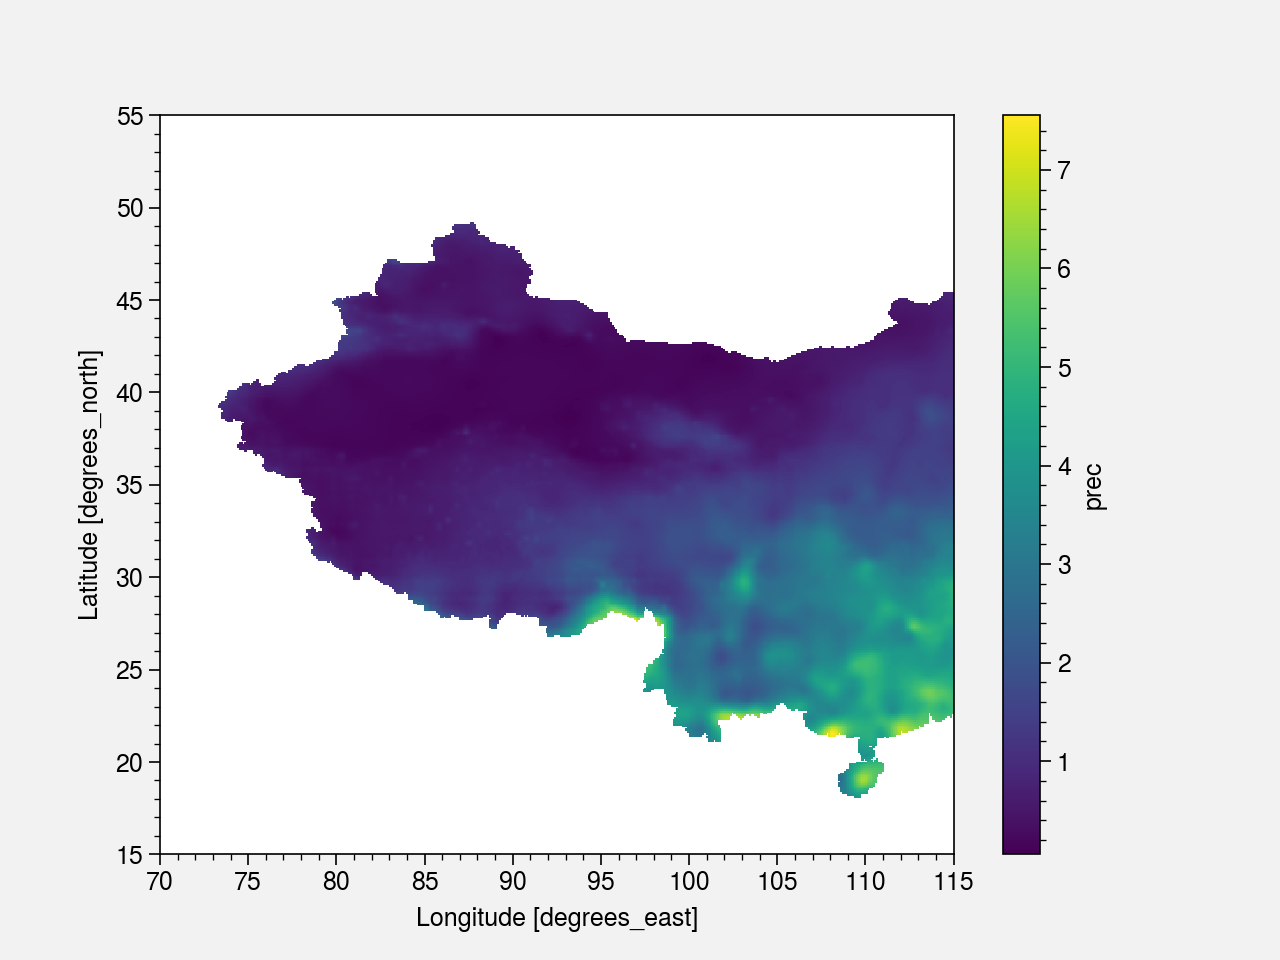

In [103]:
cmfd.mean('time').plot()

## Regrid

In [104]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

In [105]:
regridder = xe.Regridder(cmfd, cru, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
cmfd_regrid = regridder(cmfd)

Create weight file: bilinear_400x450_100x120.nc


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [106]:
regridder = xe.Regridder(gpcp, cru, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
gpcp_regrid = regridder(gpcp)

Create weight file: bilinear_20x24_100x120.nc


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


## Plot

In [46]:
u.get_domain_HMA()

(slice(20, 45, None), slice(60, 110, None))

In [107]:
latlim, lonlim = u.get_domain_HMA()

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

In [148]:
cru_seas = xr.concat([u.clim(cru, season='DJFMA'), u.clim(cru, season='JJAS')], dim='season').load()
aphro_seas = xr.concat([u.clim(aphro, season='DJFMA'), u.clim(aphro, season='JJAS')], dim='season').load()
cmfd_seas = xr.concat([u.clim(cmfd, season='DJFMA'), u.clim(cmfd, season='JJAS')], dim='season').load()
cmfd_regrid_seas = xr.concat([u.clim(cmfd_regrid, season='DJFMA'), u.clim(cmfd_regrid, season='JJAS')], dim='season').load()
gpcp_seas = xr.concat([u.clim(gpcp, season='DJFMA'), u.clim(gpcp, season='JJAS')], dim='season').load()
gpcp_regrid_seas = xr.concat([u.clim(gpcp_regrid, season='DJFMA'), u.clim(gpcp_regrid, season='JJAS')], dim='season').load()

obs_list = [
    cru_seas, gpcp_seas, cmfd_seas,
    cru_seas - aphro_seas, gpcp_regrid_seas - aphro_seas, cmfd_regrid_seas - aphro_seas,
    (cru_seas - aphro_seas)/aphro_seas*100, (gpcp_regrid_seas - aphro_seas)/aphro_seas*100, (cmfd_regrid_seas - aphro_seas)/aphro_seas*100,
]

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


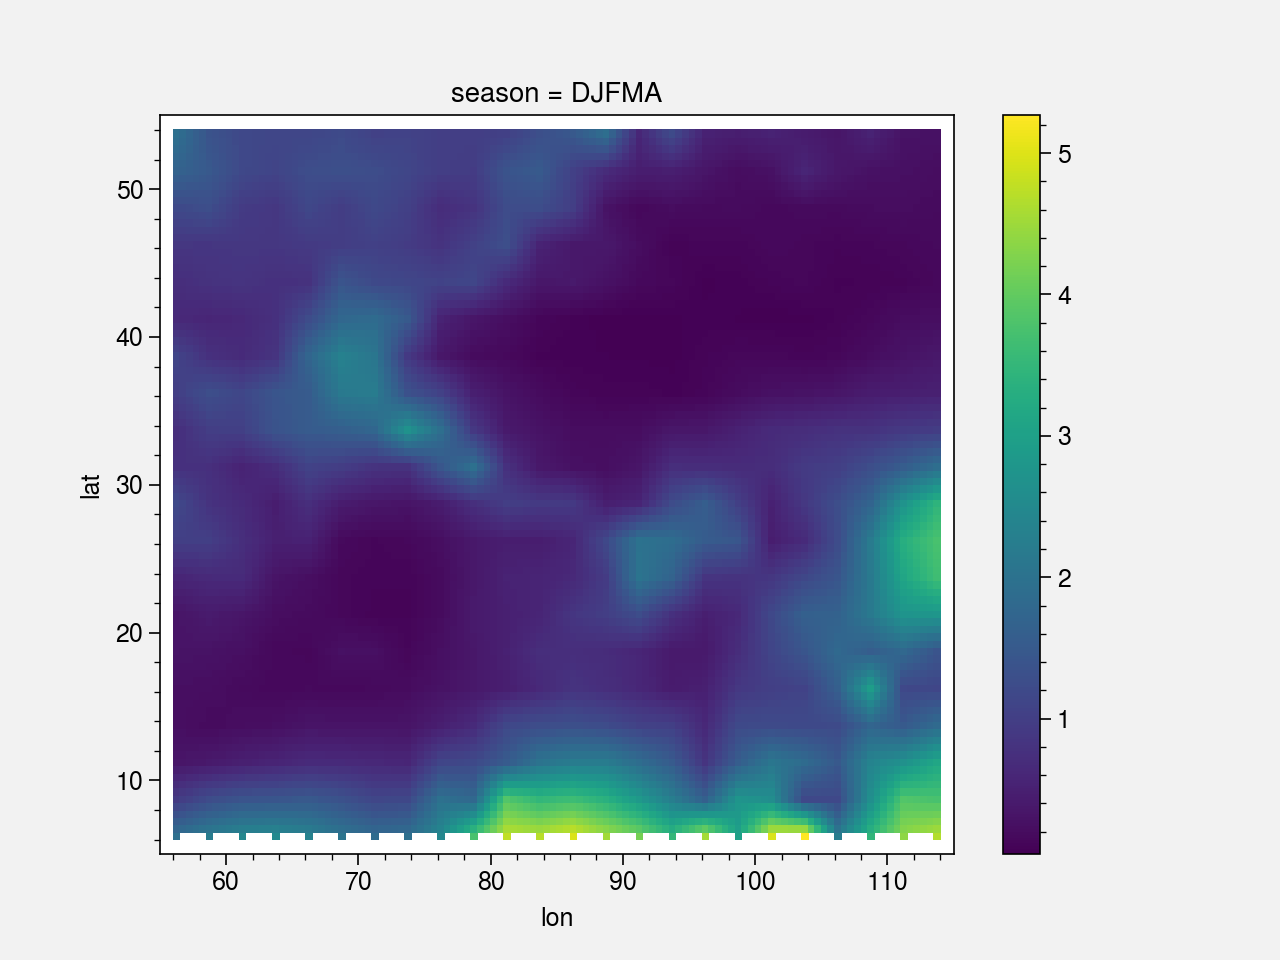

In [132]:
gpcp_regrid_seas[0].plot()

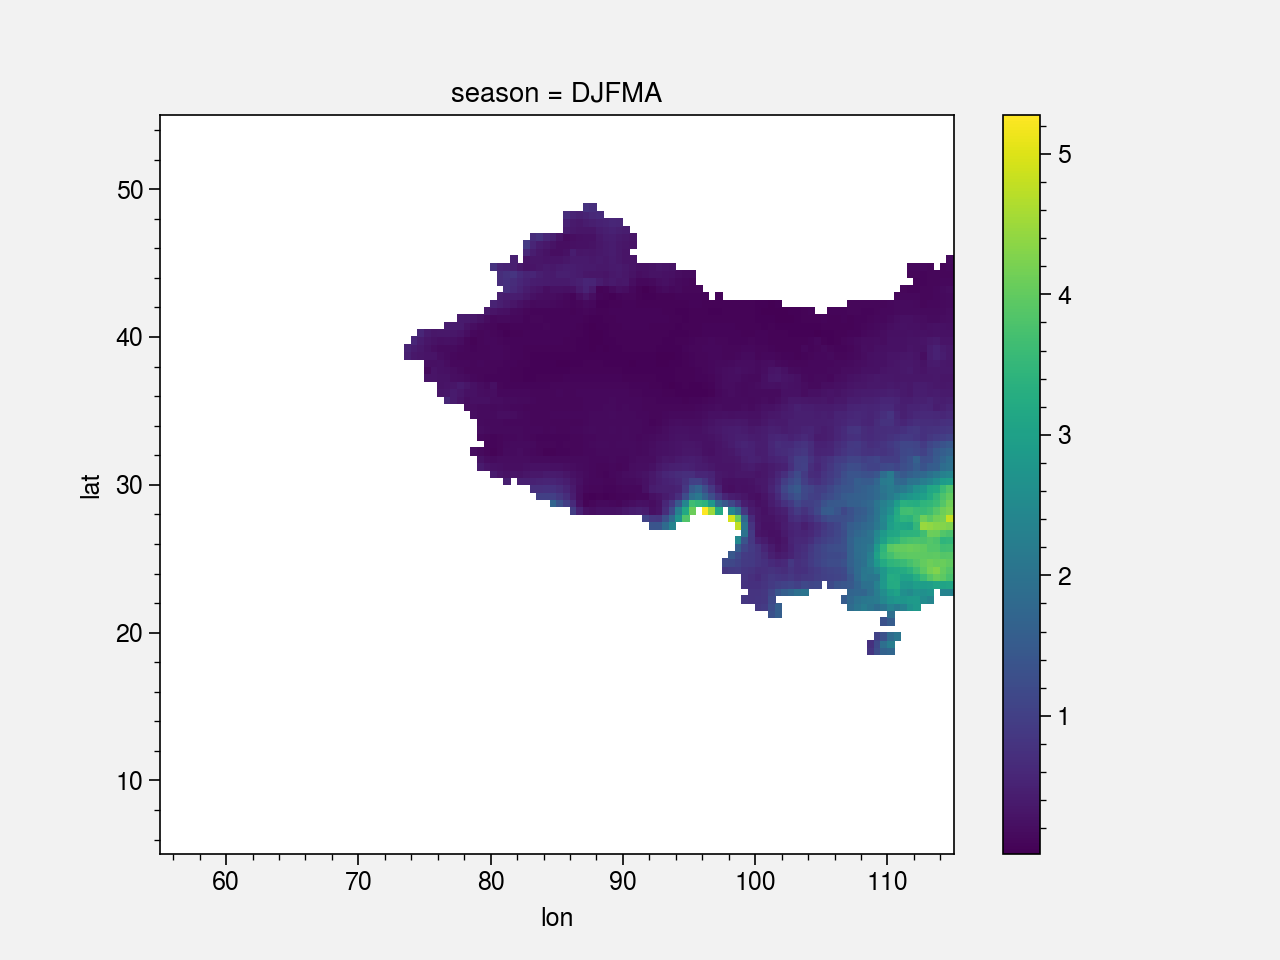

In [133]:
cmfd_regrid_seas[0].plot()

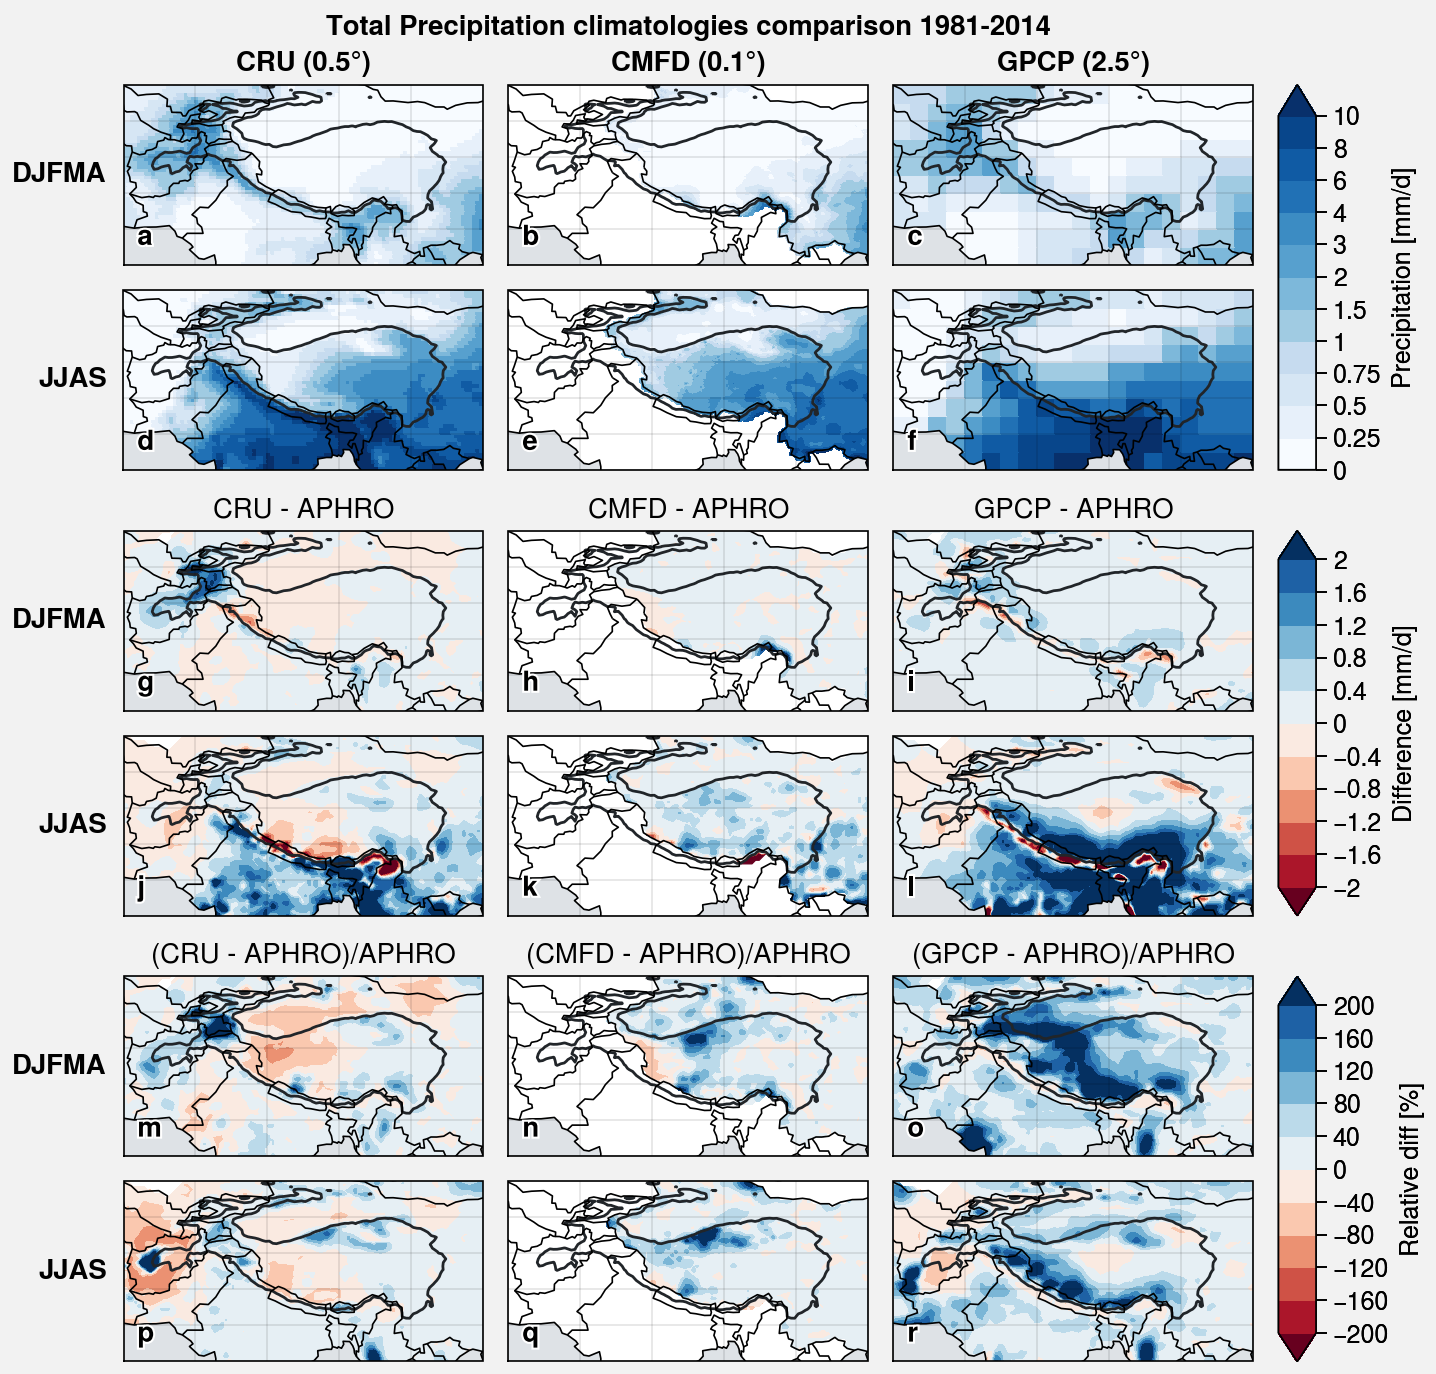

In [169]:
seasons = ['DJFMA', 'JJAS']
var = 'pr'

label, units, \
    levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)

levels_diff=plot.arange(-2, 2, 0.4)
levels=[0, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4, 6, 8, 10]
cmap = 'Blues'
units = 'mm/d'


obs_list_names = ['CRU', 'CMFD', 'GPCP']
obs_list = [cru_seas, cmfd_seas, gpcp_seas]
obs_list_diff = [cru_seas, cmfd_regrid_seas, gpcp_regrid_seas]

fig, axs = plot.subplots(ncols=3, nrows=6, proj='cyl', axwidth=1.8)

k = 0

for i_row in range(3):
    for season in seasons:
        for i, obs in enumerate(obs_list):
            if i_row == 0:
                m1 = axs[k].pcolormesh(obs.sel(season=season), cmap=cmap, levels=levels, extend='max')
            elif i_row == 1:
                m2 = axs[k].contourf(obs_list_diff[i].sel(season=season) - aphro_seas.sel(season=season), cmap=cmap_diff, levels=levels_diff, extend='both')
                if season == 'DJFMA':
                    axs[k].format(title=obs_list_names[i]+' - APHRO')
            else:
                m3 = axs[k].contourf(
                    (obs_list_diff[i].sel(season=season) - aphro_seas.sel(season=season))/aphro_seas.sel(season=season)*100, 
                    cmap=cmap_diff, levels=plot.arange(-200, 200, 40), extend='both')
                if season == 'DJFMA':
                    axs[k].format(title='('+obs_list_names[i]+' - APHRO)/APHRO')
            k += 1


fig.colorbar(m1, label='Precipitation ['+units+']', loc='r', rows=(1, 2))
fig.colorbar(m2, label='Difference ['+units+']', loc='r', rows=(3, 4))
fig.colorbar(m3, label='Relative diff [%]', loc='r', rows=(5, 6))


for ax in axs:
    ax.contour(elevation, levels=[2500], color='gray9', linewidth=1)

axs.format(
    # Grids, labels and limits
    labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    abc=True, abcloc='ll',
    rowlabels=seasons*3, collabels=['CRU (0.5°)', 'CMFD (0.1°)', 'GPCP (2.5°)'],
    suptitle=label+' climatologies comparison '+period.start+'-'+period.stop
)

for ext in ['jpg', 'pdf']:
    fig.save('img/pr_comparison_seas_1981-2014.'+ext)